<a href="https://colab.research.google.com/github/bkappala/SampleRNN-OPN/blob/master/trainRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
from torch.nn.utils.weight_norm import weight_norm
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Sampler
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import h5py
from torch import nn
import pandas as pd
import pickle

import random
from time import time
import os
import glob

import pdb
import scipy.io.wavfile

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [0]:
# !pip install scipy
torch.version.cuda


'10.1.243'

In [0]:
#!python -c 'import torch; print(torch.rand(2,3).cuda())'

In [0]:
# two_tier.py --exp AXIS1 --n_frames 12 --frame_size 10 \
# --weight_norm True --emb_size 64 --skip_conn False --dim 32 --n_rnn 2 \
# --rnn_type LSTM --learn_h0 False --q_levels 16 --q_type linear \
# --batch_size 128 --which_set MUSIC

#print "------------------previous SEQ_LEN:", SEQ_LEN
# TODO: test incremental training
#SEQ_LEN = 512 + 256
#print "---------------------------new SEQ_LEN:", SEQ_LEN
N_FRAMES = 12 # how many samples per big frame
FRAME_SIZE = 10 # How many samples per frame
OVERLAP = FRAME_SIZE
WEIGHT_NORM = True
EMB_SIZE = 64
SKIP_CONN = False
DIM = 32 # Model dimensionality.
N_RNN = 1 # How many RNNs to stack in the frame-level model
RNN_TYPE = 'LSTM'
H0_MULT = 2 if RNN_TYPE == 'LSTM' else 1
LEARN_H0 = False
Q_LEVELS = 16 # How many levels to use when discretizing samples. e.g. 256 = 8-bit scalar quantization
Q_TYPE = 'linear' # log- or linear-scale

#WHICH_SET = args.which_set
BATCH_SIZE = 64
RESUME = False
SEQ_LEN = N_FRAMES * FRAME_SIZE # Number of frames in each tRuntimeError: cuda runtime error (710) : device-side assert runcated BPTT pass
SAMPLES_PATH = "samples"
Q_ZERO = Q_LEVELS//2

#other constants
N_SEQS = 20
GRAD_CLIP = 1 # Elementwise grad clip threshold
BITRATE = 16000

# Other constants
#TRAIN_MODE = 'iters' # To use PRINT_ITERS and STOP_ITERS
TRAIN_MODE = 'time' # To use PRINT_TIME and STOP_TIME
#TRAIN_MODE = 'time-iters'
# To use PRINT_TIME for validation,
# and (STOP_ITERS, STOP_TIME), whichever happened first, for stopping exp.
#TRAIN_MODE = 'iters-time'
# To use PRINT_ITERS for validation,
# and (STOP_ITERS, STOP_TIME), whichever happened first, for stopping exp.
PRINT_ITERS = 10000 # Print cost, generate samples, save model checkpoint every N iterations.
STOP_ITERS = 100000 # Stop after this many iterations
PRINT_TIME = 90*60 # Print cost, generate samples, save model checkpoint every N seconds.
STOP_TIME = 60*60*24*3 # Stop after this many seconds of actual training (not including time req'd to generate samples etc.)
__RAND_SEED = 123


In [0]:
class FRAME_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FRAME_RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm1 = nn.LSTM(input_dim, hidden_dim).to(device)
        #pdb.set_trace()
        self.lstm1 = weight_norm(self.lstm1, 'weight_hh_l0')
        self.lstm1 = weight_norm(self.lstm1, 'weight_ih_l0')
        self.linear1 = weight_norm(nn.Linear(hidden_dim, hidden_dim, bias = True), name = 'weight').to(device)
        nn.init.kaiming_normal_(self.linear1.weight)
        self.linear2 = weight_norm(nn.Linear(DIM, FRAME_SIZE * DIM, bias = False), name = 'weight').to(device)
        nn.init.kaiming_normal_(self.linear2.weight)
        self.lstm1.flatten_parameters()

    def forward(self, input_sequences):
        self.frames = input_sequences.reshape((input_sequences.shape[1] // FRAME_SIZE, input_sequences.shape[0],
                                     FRAME_SIZE))
    
        # Rescale frames from ints in [0, Q_LEVELS) to floats in [-2, 2]
        # (a reasonable range to pass as inputs to the RNN)
        self.frames = self.frames.float()
        self.frames = (self.frames / (Q_LEVELS/2)) - 1
        self.frames *= 2
        h0 = torch.zeros(N_RNN, input_sequences.shape[0], DIM).to(device)
        c0 =  torch.zeros(N_RNN, input_sequences.shape[0], DIM).to(device)
        lstm1, _ = self.lstm1(self.frames, (h0, c0))  
        out = self.linear1(lstm1[:,:, :self.hidden_dim])
        out = self.linear2(out)
        last_hiddens = lstm1[:, -1]
        out = out.reshape((out.shape[0] * FRAME_SIZE, out.shape[1], DIM))
        return (out, last_hiddens)


In [0]:
def Embedding(n_symbols, output_dim, indices):
    vectors = torch.randn(
            n_symbols,
            output_dim).to(device)

    output_shape = [indices.shape[i] for i in range(indices.ndim)] + [output_dim]
    return vectors[indices.flatten()].reshape(output_shape)
def softmax_and_sample(logits):
    old_shape = logits.shape
    flattened_logits = (logits).flatten().double()
    samples = torch.from_numpy(np.random.multinomial(320,F.softmax(flattened_logits, dim = 0).detach().cpu().numpy()).reshape(old_shape))
    return torch.argmax(samples, axis=samples.ndim-1)

In [0]:
class SAMPLE_LEVEL(nn.Module):
    def __init__(self):
        super(SAMPLE_LEVEL, self).__init__()
        # self.input = nn.Conv1d(
        #     in_channels=Q_LEVELS,
        #     out_channels=DIM,
        #     kernel_size=FRAME_SIZE,
        #     bias=False
        # )
        self.last_out_shape = EMB_SIZE
        self.linear1 = weight_norm(nn.Linear(FRAME_SIZE * self.last_out_shape, DIM, bias = False), name = 'weight').to(device)
        nn.init.kaiming_normal_(self.linear1.weight)
        self.linear2 = weight_norm(nn.Linear(DIM, DIM, bias = True), name = 'weight').to(device)
        nn.init.kaiming_normal_(self.linear2.weight)
        self.relu1 = nn.ReLU(inplace=False).to(device)
        self.linear3 = weight_norm(nn.Linear(DIM, DIM, bias = True), name = 'weight').to(device)
        nn.init.kaiming_normal_(self.linear3.weight)
        self.relu2 = nn.ReLU(inplace=False).to(device)
        self.linear4 = weight_norm(nn.Linear(DIM, Q_LEVELS, bias = True), name = 'weight').to(device)
    
    def forward(self, frame_level_outputs, prev_samples):
        prev_samples = Embedding(Q_LEVELS, EMB_SIZE, prev_samples)
        #prev_samples = self.input(prev_samples)
        prev_samples = prev_samples.reshape((-1, FRAME_SIZE * self.last_out_shape))
        prev_samples = prev_samples.to(device)
        out = self.linear1(prev_samples)
        out += frame_level_outputs
        out = self.linear2(out)
        out = self.relu1(out)
        out = self.linear3(out)
        out = self.relu2(out)
        out = self.linear4(out)
        return out

In [0]:
class OPNDataset(Dataset):
    def __init__(self, path):
        self.files = np.load(path)
        self.batches = self._make_random_batches(self.files, BATCH_SIZE)
        self.batch_seq_len = len(self.batches[0][0])
        self.batch_seq_len = self._round_to(self.batch_seq_len, SEQ_LEN)
        self.len_dataset = self.batch_seq_len // SEQ_LEN * len(self.batches) * BATCH_SIZE
        for i, batch in enumerate(self.batches):
            self.batches[i] = np.concatenate([np.full((BATCH_SIZE, OVERLAP), Q_ZERO, dtype='int32'), batch], axis=1)
            self.batches[i] = self._normalize(batch)
            self.batches[i] = self._linear_quantize(batch)


    def __getitem__(self, index):
        
        batch_num = index // (self.batch_seq_len // SEQ_LEN * BATCH_SIZE)
        index = index % (self.batch_seq_len // SEQ_LEN * BATCH_SIZE)
        y_idx = index % (BATCH_SIZE)
        index = index // (BATCH_SIZE)
        x_idx = index % (self.batch_seq_len // SEQ_LEN)
        subbatch = self.batches[batch_num][y_idx, x_idx*SEQ_LEN : (x_idx+1)*SEQ_LEN + OVERLAP]
        input_sequences = torch.from_numpy(subbatch[:-FRAME_SIZE])
        target_sequences = torch.from_numpy(subbatch[FRAME_SIZE:])
        if y_idx == 0 and x_idx == 0:
            reset = True
        else:
            reset = False
        return (input_sequences, target_sequences, reset, subbatch)

        
    def _fixed_shuffle(self, inp_list):
        __RAND_SEED = 123
        if isinstance(inp_list, list):
            random.seed(__RAND_SEED)
            random.shuffle(inp_list)
            return
        #import collections
        #if isinstance(inp_list, (collections.Sequence)):
        if isinstance(inp_list, numpy.ndarray):
            np.random.seed(__RAND_SEED)
            np.random.shuffle(inp_list)
            return
        # destructive operations; in place; no need to return
        raise ValueError("inp_list is neither a list nor a numpy.ndarray but a "+type(inp_list))

    def _make_random_batches(self, inp_list, batch_size):
        batches = []
        for i in range(int(len(inp_list) / batch_size)):
            batches.append(inp_list[i*batch_size:(i+1)*batch_size])
        self._fixed_shuffle(batches)
        return batches
    def _round_to(self, x, y):
        return int(np.ceil(x / float(y))) * y
    def __len__(self):
        return int(self.len_dataset)
    def _linear_quantize(self, data):
    # Normalization is on mini-batch not whole file
        eps = np.float64(1e-5)
        data *= (Q_LEVELS - eps - 1)
        data += eps/2
        data = data.astype('int32')
        return data
    def _normalize(self, data):
        data -= data.min(axis=1)[:, None]
        data /= data.max(axis=1)[:, None]
        return data


In [0]:
criterion = nn.CrossEntropyLoss()
learning_rate = .0001
frame_model = FRAME_RNN(input_dim = FRAME_SIZE, hidden_dim = DIM).to(device)
sample_model = SAMPLE_LEVEL().to(device)
optimizer = torch.optim.Adam(sample_model.parameters(), lr = learning_rate)
train_dataset = OPNDataset("/content/music_train.npy")
valid_dataset = OPNDataset("/content/music_valid.npy")

train_loader = torch.utils.data.DataLoader(dataset= train_dataset,
                                                   batch_size=BATCH_SIZE,
                                                   num_workers = 1,
                                                   drop_last = False)
validation_loader = torch.utils.data.DataLoader(dataset = valid_dataset, batch_size=BATCH_SIZE, num_workers = 1,
                                                drop_last = False)

In [0]:
import warnings
warnings.filterwarnings(action='once')


In [0]:
def generate_and_save_samples(tag):
    def write_audio_file(name, data):
        data = data.numpy()
        data = data.astype('float32')
        data -= data.min()
        data /= data.max()
        data -= 0.5
        data *= 0.95
        scipy.io.wavfile.write(
                    os.path.join(SAMPLES_PATH, name+'.wav'),
                    BITRATE,
                    data)
        scipy.io
    def mu2linear(x, mu=255):
        mu = float(mu)
        x = x.astype('float32')
        y = 2. * (x - (mu+1.)/2.) / (mu+1.)
        return np.sign(y) * (1./mu) * ((1. + mu)**np.abs(y) - 1.)

    total_time = time()
    # Generate N_SEQS' sample files, each 5 seconds long
    N_SECS = 5
    LENGTH = N_SECS*BITRATE

    samples = torch.zeros((N_SEQS, LENGTH))
    samples[:, :FRAME_SIZE] = Q_ZERO
    samples = samples.to(device)
    # First half zero, others fixed random at each checkpoint
    frame_level_outputs = None
    frame_model.eval()
    sample_model.eval()
    #pdb.set_trace()
    for t in range(FRAME_SIZE, LENGTH):

        if t % FRAME_SIZE == 0:
            frame_level_outputs, _ = frame_model(samples[:, t-FRAME_SIZE:t])
        #frame_level_outputs =  F.interpolate(frame_level_outputs.view(1, 1, FRAME_SIZE, -1), size= (N_SEQS, N_SEQS * DIM), scale_factor=None, mode='nearest', align_corners=None).view(N_SEQS, N_SEQS * DIM)
        frame_level_outputs = frame_level_outputs.to(device)
        outputs = sample_model(frame_level_outputs[t % FRAME_SIZE, :, :], samples[:, t-FRAME_SIZE:t].long())    
        outputs = softmax_and_sample(outputs)
        samples[:, t] = outputs
    #pdb.set_trace()
    total_time = time() - total_time
    log = "{} samples of {} seconds length generated in {} seconds."
    log = log.format(N_SEQS, N_SECS, total_time)
    print(log)
    samples = samples.detach().cpu()
    for i in range(N_SEQS):
        samp = samples[i]
        if Q_TYPE == 'mu-law':
            samp = mu2linear(samp)
        write_audio_file("sample_{}_{}".format(tag, i), samp)

In [0]:
generate_and_save_samples('test') 

/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1268: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


20 samples of 5 seconds length generated in 85.74561834335327 seconds.


/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1268: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


Epoch[1/20], Step [100/3201], Loss: 2.8884971203
Epoch[1/20], Step [200/3201], Loss: 3.2692054835
Epoch[1/20], Step [300/3201], Loss: 2.7081621320
Epoch[1/20], Step [400/3201], Loss: 2.8278147618
Epoch[1/20], Step [500/3201], Loss: 2.7588485149
Epoch[1/20], Step [600/3201], Loss: 2.5881154900
Epoch[1/20], Step [700/3201], Loss: 2.7184157377
Epoch[1/20], Step [800/3201], Loss: 2.4226121135
Epoch[1/20], Step [900/3201], Loss: 2.3720332198
Epoch[1/20], Step [1000/3201], Loss: 2.5780395425
Epoch[1/20], Step [1100/3201], Loss: 2.7617254407
Epoch[1/20], Step [1200/3201], Loss: 3.1363567969
Epoch[1/20], Step [1300/3201], Loss: 2.4606479686
Epoch[1/20], Step [1400/3201], Loss: 2.8333376407
Epoch[1/20], Step [1500/3201], Loss: 2.7802237227
Epoch[1/20], Step [1600/3201], Loss: 2.9270253617
Epoch[1/20], Step [1700/3201], Loss: 2.5027305754
Epoch[1/20], Step [1800/3201], Loss: 2.5697671769
Epoch[1/20], Step [1900/3201], Loss: 2.6245725443
Epoch[1/20], Step [2000/3201], Loss: 2.9285298660
Epoch[1/2

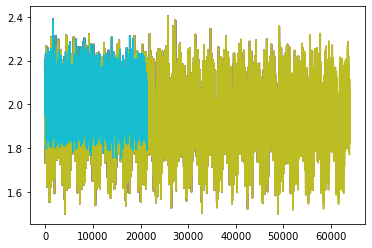

In [0]:
import pdb
soft = nn.LogSoftmax(dim=1)
num_epochs = 20
total_step = len(train_loader)
train_loss = []
size_of_frame = []
input_shapes = []
valid_cost = []
mean_valid_cost = 0
frame_model.train()
sample_model.train()
for epoch in range(num_epochs):
    for i, (input_sequences, target_sequences, reset, sequences) in enumerate(train_loader):
        input_sequences = input_sequences.to(device)
        target_sequences = target_sequences.to(device)
        sequences = sequences.to(device)
        if input_sequences.shape[1] != 120:
          continue
        frame_level_outputs, _ = frame_model(input_sequences)
        frame_level_outputs = frame_level_outputs.view(BATCH_SIZE*SEQ_LEN, DIM)
        prev_samples = sequences[:, :-1].view(1, 1, BATCH_SIZE, -1).double()
        prev_samples = prev_samples.double()
        prev_samples = F.interpolate(prev_samples, size= (BATCH_SIZE * SEQ_LEN, FRAME_SIZE), scale_factor=None, mode='nearest', align_corners=None).view(BATCH_SIZE * SEQ_LEN, FRAME_SIZE)
        prev_samples = prev_samples.long()
        #pdb.set_trace()
        sample_level_outputs = sample_model(frame_level_outputs, prev_samples)
        loss = criterion(sample_level_outputs, target_sequences.long().flatten())
        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(sample_model.parameters(), GRAD_CLIP)
        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch[{}/{}], Step [{}/{}], Loss: {:.10f}'
                    .format(epoch + 1, num_epochs, i+1, total_step, loss.item() * np.log2(np.e)))
    with torch.no_grad():
      frame_model.eval()
      sample_model.eval()
      val_steps = len(validation_loader)
      for j, (inputs, targets, r, seqs) in enumerate(validation_loader):
          inputs = inputs.to(device)
          targets = targets.to(device)
          seqs = seqs.to(device)
          if inputs.shape[1] != 120:
            continue
          valid_outputs, _ = frame_model(inputs)
          valid_outputs = valid_outputs.view(BATCH_SIZE*SEQ_LEN, DIM)
          prev_samples = seqs[:, :-1].view(1, 1, BATCH_SIZE, -1)
          prev_samples = prev_samples.double()
          prev_samples = F.interpolate(prev_samples, size= (BATCH_SIZE * SEQ_LEN, FRAME_SIZE), scale_factor=None, mode='nearest', align_corners=None).view(BATCH_SIZE * SEQ_LEN, FRAME_SIZE)
          prev_samples = prev_samples.long()
          outputs = sample_model(valid_outputs, prev_samples)
          loss = criterion(outputs, targets.long().flatten())
          valid_cost.append(loss.item())
          if (j+1) % 100 == 0:
            print ('Epoch[{}/{}], Step [{}/{}], Loss: {:.10f}'
                    .format(epoch + 1, num_epochs, j+1, val_steps, loss.item() * np.log2(np.e)))
    plt.plot(train_loss)
    plt.plot(valid_cost)
    # if epoch % 10 == 0:
    #     generate_and_save_samples()
    frame_model.train()
    sample_model.train()

In [0]:
def _fixed_shuffle(inp_list):
        __RAND_SEED = 123
        if isinstance(inp_list, list):
            random.seed(__RAND_SEED)
            random.shuffle(inp_list)
            return
        #import collections
        #if isinstance(inp_list, (collections.Sequence)):
        if isinstance(inp_list, numpy.ndarray):
            np.random.seed(__RAND_SEED)
            np.random.shuffle(inp_list)
            return
        # destructive operations; in place; no need to return
        raise ValueError("inp_list is neither a list nor a numpy.ndarray but a "+type(inp_list))

def _make_random_batches(inp_list, batch_size):
    batches = []
    for i in range(int(len(inp_list) / batch_size)):
        batches.append(inp_list[i*batch_size:(i+1)*batch_size])
    _fixed_shuffle(batches)
    return batches
def _round_to(x, y):
    return int(np.ceil(x / float(y))) * y

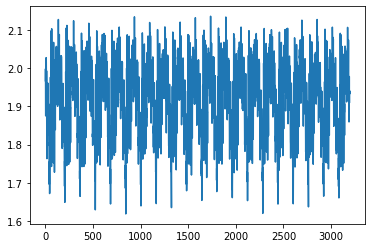

In [0]:
# plt.plot(np.mean(np.asarray(train_loss)))
train_loss = np.asarray(train_loss)
train_loss = np.mean(train_loss.reshape(-1, 20), axis=1)
plt.plot(train_loss)

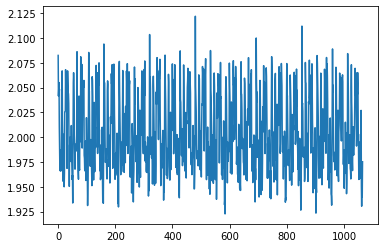

In [0]:
valid_cost = np.asarray(valid_cost)
valid_cost = np.mean(valid_cost.reshape(-1, 20), axis=1)
plt.plot(valid_cost)

In [0]:
loss = nn.CrossEntropyLoss()
input = torch.randn(7680, 16, requires_grad=True)
target = torch.zeros(7680, dtype=torch.long).random_(2)
output = loss(input, target)
output.item()

In [0]:
test = torch.randint(high = 10, size = (1, 1, 64, 129)).double()
m = nn.Upsample(size = (BATCH_SIZE * SEQ_LEN, FRAME_SIZE))
torch.unique(m(test))

In [0]:
files = np.load("/content/music_train.npy")
batches = _make_random_batches(files, BATCH_SIZE)
batch_seq_len = len(batches[0][0])  # should be 8*16000
batch_seq_len = _round_to(batch_seq_len, SEQ_LEN)
batch_seq_len
batch = np.concatenate([
                np.full((BATCH_SIZE, OVERLAP), Q_ZERO, dtype='int32'),
                batches[0]
            ], axis=1)
batch_seq_len // SEQ_LEN 
#len(batches) #* BATCH_SIZE

# for i, data in enumerate(batches[0]):
#     #data, fs, enc = scikits.audiolab.flacread(path)
#     # data is float16 from reading the npy file
#     print("i is")
#     print(i)
#     print("data shape")
#     print(data.shape)
#     # This shouldn't change anything. All the flac files for Blizz
#     # are the same length and the mask should be 1 every where.
#     # mask[i, len(data):] = numpy.float32(0)

In [0]:
batches[0][0].shape
SEQ_LEN

In [0]:
index = 47999
Tindex = index
batch_num = index // (batch_seq_len // SEQ_LEN * BATCH_SIZE)
index = index % (batch_seq_len // SEQ_LEN * BATCH_SIZE)
y_idx = index % (BATCH_SIZE)
index = index // (BATCH_SIZE)
x_idx = index % (batch_seq_len // SEQ_LEN)
subbatch = batches[batch_num][y_idx, x_idx*SEQ_LEN : (x_idx+1)*SEQ_LEN + OVERLAP]
input_sequences = subbatch[:-FRAME_SIZE]
target_sequences = subbatch[FRAME_SIZE:]
[Tindex, batch_num, y_idx, x_idx]

In [0]:
fold = nn.Fold(output_size=(1, FRAME_SIZE), kernel_size=(1, 1))

In [0]:
batch_num = index // (self.batch_seq_len // SEQ_LEN)
        per_batch_sample = index % (self.batch_seq_len // SEQ_LEN)
        subbatch = self.batches[batch_num][:, i*SEQ_LEN : (i+1)*SEQ_LEN + OVERLAP]
        input_sequences = subbatch[:, :-FRAME_SIZE]
        target_sequences = subbatch[:, FRAME_SIZE:]

In [0]:
def Embedding(n_symbols, output_dim, indices):
    vectors = np.random.randn(
            n_symbols,
            output_dim)

    output_shape = [indices.shape[i] for i in range(indices.ndim)] + [output_dim]
    return vectors[indices.flatten()].reshape(output_shape)

In [0]:
test = torch.from_numpy(np.random.randn(64, 16, 516)).float()
frame = torch.from_numpy(np.random.randn(7680, 32)).float()
input_val = nn.Conv1d(
            in_channels=Q_LEVELS,
            out_channels=DIM,
            kernel_size=256,
            bias=False
        )
input_val(test).shape
#torch.Size([7680, 32])
##TO DO
##CHECK HOW MANY SAMPLES PER AN ELEMENT OF BATCH
##IMPLEMENT DATASET CLASS
##TRAINING LOOP
##TRAIN ON GPU


In [0]:
frame = torch.from_numpy(np.random.randn(64, 129)).long()
Embedding(Q_LEVELS, EMB_SIZE, frame).shape

In [0]:
input_expand = torch.nn.Conv1d(
            in_channels=N_FRAMES,
            out_channels=DIM,
            kernel_size=1
        )

In [0]:
frame = torch.from_numpy(np.random.randn(64, 130)).float()
input_expand(frame).shape